Epoch 1/50, Loss: 0.1237
Epoch 2/50, Loss: 0.0540
Epoch 3/50, Loss: 0.0472
Epoch 4/50, Loss: 0.0406
Epoch 5/50, Loss: 0.0383
Epoch 6/50, Loss: 0.0380
Epoch 7/50, Loss: 0.0377
Epoch 8/50, Loss: 0.0386
Epoch 9/50, Loss: 0.0360
Epoch 10/50, Loss: 0.0356
Epoch 11/50, Loss: 0.0351
Epoch 12/50, Loss: 0.0348
Epoch 13/50, Loss: 0.0362
Epoch 14/50, Loss: 0.0354
Epoch 15/50, Loss: 0.0346
Epoch 16/50, Loss: 0.0353
Epoch 17/50, Loss: 0.0344
Epoch 18/50, Loss: 0.0337
Epoch 19/50, Loss: 0.0337
Epoch 20/50, Loss: 0.0335
Epoch 21/50, Loss: 0.0335
Epoch 22/50, Loss: 0.0331
Epoch 23/50, Loss: 0.0334
Epoch 24/50, Loss: 0.0324
Epoch 25/50, Loss: 0.0329
Epoch 26/50, Loss: 0.0324
Epoch 27/50, Loss: 0.0338
Epoch 28/50, Loss: 0.0319
Epoch 29/50, Loss: 0.0329
Epoch 30/50, Loss: 0.0314
Epoch 31/50, Loss: 0.0317
Epoch 32/50, Loss: 0.0316
Epoch 33/50, Loss: 0.0312
Epoch 34/50, Loss: 0.0306
Epoch 35/50, Loss: 0.0306
Epoch 36/50, Loss: 0.0309
Epoch 37/50, Loss: 0.0313
Epoch 38/50, Loss: 0.0325
Epoch 39/50, Loss: 0.

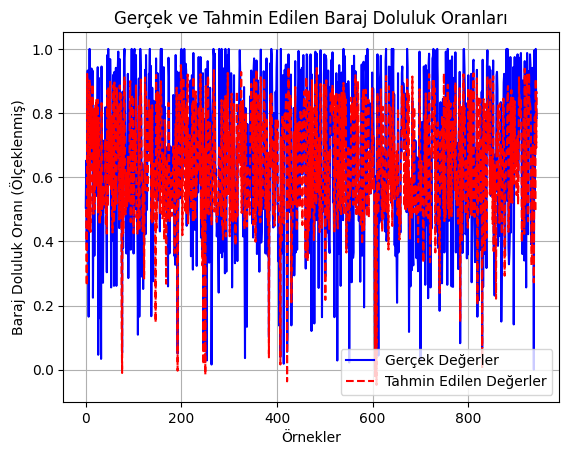

In [1]:
# FEDFORMER MODELİ
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
# Excel verilerini yükleme
data = pd.read_excel('terkosBarajı.xlsx')
data['datetime'] = pd.to_datetime(data['datetime'])  # Tarih sütununu datetime tipine çevirin

# Verilerin ölçeklenmesi
features = ['temp', 'dew', 'humidity', 'precip',
            'windspeed', 'sealevelpressure', 'cloudcover', 'daylight_duration']
target = 'doluluk'

scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Veri setini giriş ve çıkış olarak ayırın
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length, :-1]
        label = data[i + seq_length, -1]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

seq_length = 30  # 30 günlük geçmiş veri kullanacağız
data_array = data[features + [target]].values
X, y = create_sequences(data_array, seq_length)

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset ve DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# FEDformer modelini tanımlayın
class FEDformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FEDformer, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Son zaman adımını alın
        out = self.fc(out)
        return out

# Model oluşturma
input_size = len(features)
hidden_size = 64
output_size = 1

model = FEDformer(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Test etme
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(output.numpy())

# Hesaplamalar
y_true = np.array(y_true)
y_pred = np.array(y_pred).flatten()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)


epsilon = 1e-5  # Çok küçük bir değer
valid_indices = y_true > epsilon  # Sadece bu koşulu sağlayanları al
y_true_filtered = y_true[valid_indices]
y_pred_filtered = y_pred[valid_indices]

# Filtrelenmiş değerler ile MAPE hesaplaması
mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-Squared: {r2:.4f}")

# Modelin tahmin yapması
def predict(data, model, scaler, seq_length):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(data[-seq_length:, :-1].reshape(1, seq_length, -1), dtype=torch.float32)
        prediction = model(inputs).item()
    return scaler.inverse_transform([[0] * (len(features)) + [prediction]])[0, -1]
    plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='Tahmin Edilen Değerler', color='red', linestyle='--')
plt.title('Gerçek ve Tahmin Edilen Baraj Doluluk Oranları')
plt.xlabel('Örnekler')
plt.ylabel('Baraj Doluluk Oranı (Ölçeklenmiş)')
plt.legend()
plt.grid(True)
plt.show()



Sayısal sütunlar: Index(['temp', 'dew', 'humidity', 'precip', 'windspeed', 'sealevelpressure',
       'cloudcover', 'daylight_duration', 'doluluk'],
      dtype='object')


<ipython-input-2-2361d6085627>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 1/10, Train Loss: 0.1595178914980756, Test Loss: 0.07072998032488517
Train MSE: 0.16024109893162286, Test MSE: 0.0729718175131164
Train MAPE: 49.82975721359253%, Test MAPE: inf%
Train MAE: 0.30640407197368397, Test MAE: 0.23567065972333345
Train RMSE: 0.40030126021738033, Test RMSE: 0.27013296265564557
Train R²: -2.529094813600256, Test R²: -0.9280577569146937
Training Time: 68.24016571044922 seconds, Inference Time: 2.9339749813079834 seconds


<ipython-input-2-2361d6085627>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 2/10, Train Loss: 0.13970644389175707, Test Loss: 0.026746390876436828
Train MSE: 0.13956061067493666, Test MSE: 0.027652233367454034
Train MAPE: 45.74754536151886%, Test MAPE: inf%
Train MAE: 0.2793960482567905, Test MAE: 0.13862414914103718
Train RMSE: 0.3735781185708508, Test RMSE: 0.16628960691352312
Train R²: -2.0736348577213, Test R²: 0.2693740562162662
Training Time: 59.32063007354736 seconds, Inference Time: 3.8881349563598633 seconds


<ipython-input-2-2361d6085627>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 3/10, Train Loss: 0.1194300578251757, Test Loss: 0.00745579112002528
Train MSE: 0.11947417232291649, Test MSE: 0.007390485792645161
Train MAPE: 32.67555236816406%, Test MAPE: inf%
Train MAE: 0.21443526406886104, Test MAE: 0.07560636234374192
Train RMSE: 0.3456503613811455, Test RMSE: 0.08596793467709435
Train R²: -1.6312580524919245, Test R²: 0.8047289495384148
Training Time: 59.37044405937195 seconds, Inference Time: 2.2228193283081055 seconds


<ipython-input-2-2361d6085627>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 4/10, Train Loss: 0.10851007303292001, Test Loss: 0.007241460526098595
Train MSE: 0.10886648322353039, Test MSE: 0.007427386881635231
Train MAPE: 24.745886027812958%, Test MAPE: inf%
Train MAE: 0.16765441566471312, Test MAE: 0.07031598207063208
Train RMSE: 0.3299492130973044, Test RMSE: 0.08618228867717097
Train R²: -1.3976379585552143, Test R²: 0.803753950788341
Training Time: 61.173001527786255 seconds, Inference Time: 3.2775330543518066 seconds


<ipython-input-2-2361d6085627>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 5/10, Train Loss: 0.1111180840956944, Test Loss: 0.006162662847552718
Train MSE: 0.11140953284748395, Test MSE: 0.006302312596496575
Train MAPE: 23.678334057331085%, Test MAPE: inf%
Train MAE: 0.16333455017051923, Test MAE: 0.0653777622900362
Train RMSE: 0.333780665778418, Test RMSE: 0.0793871059838849
Train R²: -1.4536452082462077, Test R²: 0.833480607962214
Training Time: 59.040879249572754 seconds, Inference Time: 3.536105155944824 seconds


<ipython-input-2-2361d6085627>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 6/10, Train Loss: 0.11078630234287293, Test Loss: 0.005021104412183999
Train MSE: 0.1106556287079393, Test MSE: 0.005115324478293922
Train MAPE: 23.559552431106567%, Test MAPE: inf%
Train MAE: 0.1609523094476502, Test MAE: 0.05918478921222954
Train RMSE: 0.33264940809798427, Test RMSE: 0.07152149661670903
Train R²: -1.437041482943786, Test R²: 0.8648431493742439
Training Time: 59.3319296836853 seconds, Inference Time: 2.951139211654663 seconds


<ipython-input-2-2361d6085627>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 7/10, Train Loss: 0.10268191717289112, Test Loss: 0.005464760340002708
Train MSE: 0.10280249693966834, Test MSE: 0.005408836933213762
Train MAPE: 22.018975019454956%, Test MAPE: inf%
Train MAE: 0.15087457502544568, Test MAE: 0.06692129492035342
Train RMSE: 0.32062828468441196, Test RMSE: 0.07354479541894016
Train R²: -1.2640868116471884, Test R²: 0.857087977792317
Training Time: 62.446736335754395 seconds, Inference Time: 6.806788444519043 seconds


<ipython-input-2-2361d6085627>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 8/10, Train Loss: 0.10949313016263423, Test Loss: 0.0038510314908834467
Train MSE: 0.10941841752568782, Test MSE: 0.003742663881253535
Train MAPE: 23.18926602602005%, Test MAPE: inf%
Train MAE: 0.15776973760513463, Test MAE: 0.05487900930377217
Train RMSE: 0.3307845484990008, Test RMSE: 0.06117731508699556
Train R²: -1.4097935696698323, Test R²: 0.9011115198483541
Training Time: 64.86231923103333 seconds, Inference Time: 3.012697458267212 seconds


<ipython-input-2-2361d6085627>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 9/10, Train Loss: 0.10525972136356695, Test Loss: 0.004395126213478905
Train MSE: 0.10596056955129148, Test MSE: 0.004295812260129798
Train MAPE: 22.51538783311844%, Test MAPE: inf%
Train MAE: 0.15375948438847895, Test MAE: 0.05735529938863956
Train RMSE: 0.32551585145932826, Test RMSE: 0.0655424462476783
Train R²: -1.3336391159496448, Test R²: 0.8864962607118325
Training Time: 61.28749942779541 seconds, Inference Time: 3.4750280380249023 seconds


<ipython-input-2-2361d6085627>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 10/10, Train Loss: 0.10549235199060705, Test Loss: 0.004561663458987728
Train MSE: 0.1052843507007352, Test MSE: 0.0044159114192848315
Train MAPE: 22.26049154996872%, Test MAPE: inf%
Train MAE: 0.15201540702360905, Test MAE: 0.057988305313862926
Train RMSE: 0.3244755009253167, Test RMSE: 0.0664523244084421
Train R²: -1.3187463047153982, Test R²: 0.8833230066625392
Training Time: 58.829628705978394 seconds, Inference Time: 3.035675287246704 seconds


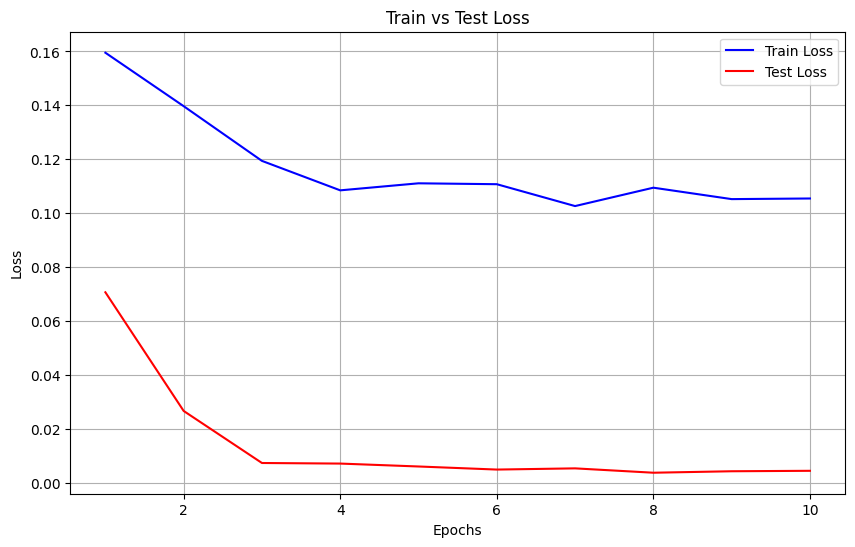

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time  # TFT MODELİ

# Küçük bir sabit ekleyerek sıfır bölme hatasını engelleme
epsilon = 1e-6  # Küçük bir sabit

# Veriyi yükleme
file_path = "terkosBarajı.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "doluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("doluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):  # Yapıcı metodun doğru tanımı
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):  # Veri setinin uzunluğunu döner
        return len(self.X)

    def __getitem__(self, index):  # Belirtilen indeks için X ve y değerlerini döner
        return self.X[index], self.y[index]

# Dataset ve DataLoader oluşturma
train_dataset = TimeSeriesDataset(X_train, y_train)  # Burada hata alınmamalı
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Düzeltildi
        super(TemporalFusionTransformer, self).__init__()
        # LSTM katmanı (geleneksel zaman serisi öğrenme)
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # TFT'nin temel bileşenlerinden olan konvasyonel katmanlar
        self.attn_layer = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Diğer TFT katmanları (eklenebilir)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # LSTM katmanı çıkışı
        lstm_out, _ = self.lstm(x)

        # Multihead Attention katmanı (geleneksel zaman serisi için)
        attn_out, _ = self.attn_layer(lstm_out, lstm_out, lstm_out)

        # TFT modelindeki tam bağlı katman
        output = self.fc(attn_out[:, -1, :])  # Sadece son zaman dilimindeki tahmin
        output = self.dropout(output)
        return output


# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 64  # LSTM katmanının gizli boyutu
output_dim = 1  # Baraj doluluk yüzdesi

# Modeli oluşturma
model = TemporalFusionTransformer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()  # Kayıp fonksiyonu (Mean Squared Error)
optimizer = Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 10  # Eğitim süresini artırdım
train_losses = []
test_losses = []

# Eğitim ve çıkarım sürelerini kaydetmek için listeler
train_times = []
inference_times = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    start_train = time.time()  # Eğitim zamanı başlat
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())
    end_train = time.time()  # Eğitim zamanı bitir
    train_times.append(end_train - start_train)  # Eğitim süresini kaydet

    train_losses.append(train_loss / len(train_loader))

    # Eğitim metriklerini hesapla
    train_mse = mean_squared_error(train_actuals, train_preds)
    train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
    train_mae = mean_absolute_error(train_actuals, train_preds)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(train_actuals, train_preds)

    # Test değerlendirme
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    start_inference = time.time()  # Çıkarım zamanı başlat
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())
    end_inference = time.time()  # Çıkarım zamanı bitir
    inference_times.append(end_inference - start_inference)  # Çıkarım süresini kaydet

    test_losses.append(test_loss / len(test_loader))

    test_mse = mean_squared_error(test_actuals, test_preds)
    test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100
    test_mae = mean_absolute_error(test_actuals, test_preds)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_actuals, test_preds)

    # Sonuçları yazdırma
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train MAPE: {train_mape}%, Test MAPE: {test_mape}%")
    print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train R²: {train_r2}, Test R²: {test_r2}")
    print(f"Training Time: {train_times[-1]} seconds, Inference Time: {inference_times[-1]} seconds")

# Gerçek ve tahmin edilen değerleri birleştirip Excel dosyasına kaydetme (Eğitim ve çıkarım süreleri hariç)
result_df = pd.DataFrame({
    'Gerçek Değerler': test_actuals,
    'Tahminler': test_preds
})

# Excel dosyasına kaydetme
result_df.to_excel("baraj_doluluk_tahminleri.xlsx", index=False)

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.0905
Epoch 2/50, Loss: 0.0515
Epoch 3/50, Loss: 0.0474
Epoch 4/50, Loss: 0.0456
Epoch 5/50, Loss: 0.0443
Epoch 6/50, Loss: 0.0434
Epoch 7/50, Loss: 0.0429
Epoch 8/50, Loss: 0.0426
Epoch 9/50, Loss: 0.0420
Epoch 10/50, Loss: 0.0418
Epoch 11/50, Loss: 0.0412
Epoch 12/50, Loss: 0.0418
Epoch 13/50, Loss: 0.0410
Epoch 14/50, Loss: 0.0407
Epoch 15/50, Loss: 0.0403
Epoch 16/50, Loss: 0.0406
Epoch 17/50, Loss: 0.0410
Epoch 18/50, Loss: 0.0414
Epoch 19/50, Loss: 0.0397
Epoch 20/50, Loss: 0.0399
Epoch 21/50, Loss: 0.0397
Epoch 22/50, Loss: 0.0397
Epoch 23/50, Loss: 0.0395
Epoch 24/50, Loss: 0.0396
Epoch 25/50, Loss: 0.0390
Epoch 26/50, Loss: 0.0392
Epoch 27/50, Loss: 0.0396
Epoch 28/50, Loss: 0.0394
Epoch 29/50, Loss: 0.0387
Epoch 30/50, Loss: 0.0387
Epoch 31/50, Loss: 0.0385
Epoch 32/50, Loss: 0.0392
Epoch 33/50, Loss: 0.0385
Epoch 34/50, Loss: 0.0391
Epoch 35/50, Loss: 0.0387
Epoch 36/50, Loss: 0.0381
Epoch 37/50, Loss: 0.0385
Epoch 38/50, Loss: 0.0381
Epoch 39/50, Loss: 0.

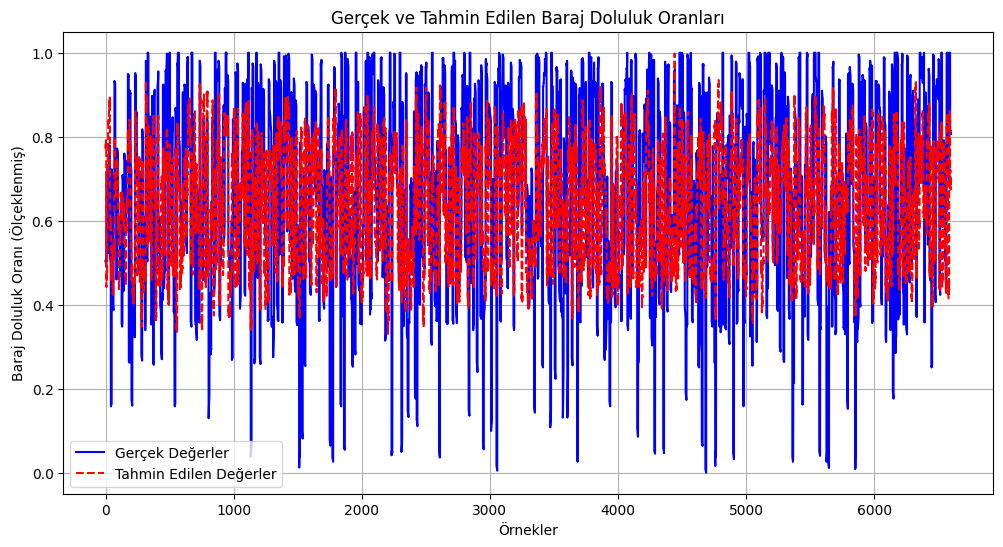

In [3]:
# İNFORMER
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

data = pd.read_excel('terkosBarajı.xlsx')
data['datetime'] = pd.to_datetime(data['datetime'])  # Tarih sütununu datetime tipine çevirin

# Verilerin ölçeklenmesi
features = ['temp', 'dew', 'humidity', 'precip',
            'windspeed', 'sealevelpressure', 'cloudcover', 'daylight_duration']
target = 'doluluk'


scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Veri setini giriş ve çıkış olarak ayırma
def create_sequences(data, input_len, pred_len):
    X, y = [], []
    for i in range(len(data) - input_len - pred_len):
        X.append(data[i:i + input_len, :-1])
        y.append(data[i + input_len:i + input_len + pred_len, -1])
    return np.array(X), np.array(y)

input_len = 30  # Geçmiş 30 gün
pred_len = 7    # Tahmin edilen 7 gün
data_array = data[features + [target]].values
X, y = create_sequences(data_array, input_len, pred_len)

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset ve DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Informer modeli
class Informer(nn.Module):
    def __init__(self, input_size, seq_len, pred_len, d_model, num_heads, num_layers):
        super(Informer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(seq_len * input_size, pred_len)

    def forward(self, x):
        batch_size, seq_len, input_size = x.size()
        x = x.view(batch_size, seq_len * input_size)  # Flatten for linear layer
        x = self.fc(x)
        return x

# Model oluşturma
input_size = len(features)
d_model = 64
num_heads = 4
num_layers = 2

model = Informer(input_size, seq_len=input_len, pred_len=pred_len,
                 d_model=d_model, num_heads=num_heads, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Test etme
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.numpy().flatten())
        y_pred.extend(output.numpy().flatten())

# Performans metrikleri
# Performans metrikleri
y_true = np.array(y_true)
y_pred = np.array(y_pred)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-Squared: {r2:.4f}")

# Tahmin ve görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='Tahmin Edilen Değerler', color='red', linestyle='--')
plt.title('Gerçek ve Tahmin Edilen Baraj Doluluk Oranları')
plt.xlabel('Örnekler')
plt.ylabel('Baraj Doluluk Oranı (Ölçeklenmiş)')
plt.legend()
plt.grid(True)
plt.show()


Sayısal sütunlar: Index(['temp', 'dew', 'humidity', 'precip', 'windspeed', 'sealevelpressure',
       'cloudcover', 'daylight_duration', 'doluluk'],
      dtype='object')


<ipython-input-5-0535a5c0b00b>:158: RuntimeWarning: divide by zero encountered in divide
  test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)


Epoch 1/3, Train Loss: 0.06974871017263029, Test Loss: 0.05483655899910158
Train MSE: 0.07020288247870839, Test MSE: 0.05672904613862717
Train MAPE: 32.77446627616882%, Test MAPE: inf%
Train MAE: 0.19503509272877403, Test MAE: 0.21039701546144346
Train RMSE: 0.26495826554140256, Test RMSE: 0.23817860134493016
Train R²: -0.5461241223833442, Test R²: -0.4988920541864206
Training time for epoch 1: 78.59 seconds
Inference time for epoch 1: 0.57 seconds


<ipython-input-5-0535a5c0b00b>:158: RuntimeWarning: divide by zero encountered in divide
  test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)


Epoch 2/3, Train Loss: 0.0028648278368766317, Test Loss: 0.005768777044355183
Train MSE: 0.0028734866200004826, Test MSE: 0.005807403075499899
Train MAPE: 7.311948388814926%, Test MAPE: inf%
Train MAE: 0.039729230537763185, Test MAE: 0.06487259501869926
Train RMSE: 0.05360491227490707, Test RMSE: 0.07620631913102678
Train R²: 0.9367153196326952, Test R²: 0.846557082873327
Training time for epoch 2: 12.39 seconds
Inference time for epoch 2: 0.62 seconds


<ipython-input-5-0535a5c0b00b>:158: RuntimeWarning: divide by zero encountered in divide
  test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)


Epoch 3/3, Train Loss: 0.0010508464878916533, Test Loss: 0.0028304354552682
Train MSE: 0.0010568487929494212, Test MSE: 0.002629993786217816
Train MAPE: 3.901192918419838%, Test MAPE: inf%
Train MAE: 0.022914322557027092, Test MAE: 0.040169640064128063
Train RMSE: 0.03250921089398236, Test RMSE: 0.05128346503716199
Train R²: 0.9767243259137344, Test R²: 0.930510434124198
Training time for epoch 3: 12.71 seconds
Inference time for epoch 3: 0.71 seconds


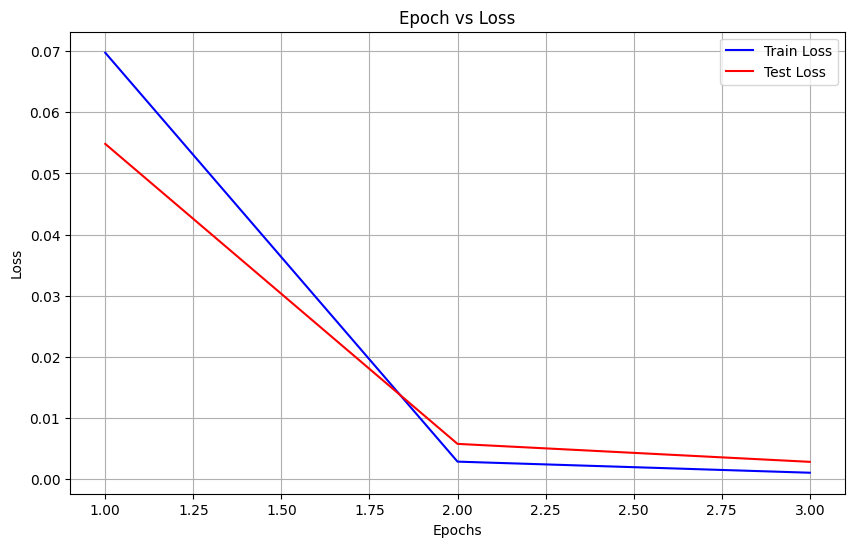

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ETSFORMER yükleme
file_path = "terkosBarajı.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)  # Hangi sütunların seçildiğini kontrol edebilirsiniz

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "doluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("doluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):  # Doğru yazım: __init__
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):  # Doğru yazım: __len__
        return len(self.X)

    def __getitem__(self, index):  # Doğru yazım: __getitem__
        return self.X[index], self.y[index]

# Dataset ve DataLoader
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Basit bir ETSFormer modeli (örnek olarak LSTM temelli)
class SimpleETSFormer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Doğru yazım: __init__
        super(SimpleETSFormer, self).__init__()  # Doğru yazım: __init__
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output


# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 64
output_dim = 1  # Baraj doluluk yüzdesi

model = SimpleETSFormer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Eğitim ve test kayıplarını saklamak için listeler
train_losses = []
test_losses = []

# Eğitim ve test metriklerini saklamak için listeler
train_mse, train_mape, train_mae, train_rmse, train_r2 = [], [], [], [], []
test_mse, test_mape, test_mae, test_rmse, test_r2 = [], [], [], [], []

# Model eğitimi ve değerlendirme
epochs = 3
for epoch in range(epochs):
    start_train_time = time.time()  # Eğitim başlangıç zamanı
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())

    # Eğitim süresi
    train_time = time.time() - start_train_time

    # Eğitim metriklerini hesapla
    train_mse.append(mean_squared_error(train_actuals, train_preds))
    train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)
    train_mae.append(mean_absolute_error(train_actuals, train_preds))
    train_rmse.append(np.sqrt(mean_squared_error(train_actuals, train_preds)))
    train_r2.append(r2_score(train_actuals, train_preds))

    # Eğitim kaybını kaydetme
    train_losses.append(train_loss / len(train_loader))

    # Test değerlendirme
    start_test_time = time.time()  # Test başlangıç zamanı
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())

    # Test süresi
    test_time = time.time() - start_test_time

    # Test metriklerini hesapla
    test_mse.append(mean_squared_error(test_actuals, test_preds))
    test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)
    test_mae.append(mean_absolute_error(test_actuals, test_preds))
    test_rmse.append(np.sqrt(mean_squared_error(test_actuals, test_preds)))
    test_r2.append(r2_score(test_actuals, test_preds))

    # Test kaybını kaydetme
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse[-1]}, Test MSE: {test_mse[-1]}")
    print(f"Train MAPE: {train_mape[-1]}%, Test MAPE: {test_mape[-1]}%")
    print(f"Train MAE: {train_mae[-1]}, Test MAE: {test_mae[-1]}")
    print(f"Train RMSE: {train_rmse[-1]}, Test RMSE: {test_rmse[-1]}")
    print(f"Train R²: {train_r2[-1]}, Test R²: {test_r2[-1]}")
    print(f"Training time for epoch {epoch+1}: {train_time:.2f} seconds")
    print(f"Inference time for epoch {epoch+1}: {test_time:.2f} seconds")

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

Index(['name', 'datetime', 'temp', 'dew', 'humidity', 'precip', 'windspeed',
       'sealevelpressure', 'cloudcover', 'daylight_duration', 'doluluk'],
      dtype='object')
            temp  dew  humidity  precip  windspeed  sealevelpressure  \
datetime                                                               
2011-01-01   3.7 -0.5      74.8   0.000       15.4            1020.4   
2011-01-02   7.8  1.0      62.7   0.000       21.1            1015.8   
2011-01-03   7.3  3.6      78.6   2.517       33.2            1011.9   
2011-01-04   4.8  2.3      84.3   6.375       35.6            1019.3   
2011-01-05   5.5 -0.2      67.1   0.000       26.4            1023.6   

            cloudcover  daylight_duration  doluluk  weighted_score  
datetime                                                            
2011-01-01         9.1         555.716667    91.87        178.8860  
2011-01-02        42.9         556.450000    91.68        180.9940  
2011-01-03        89.5         557.266667    9

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                doluluk   No. Observations:                 3323
Model:                ARIMA(10, 1, 5)   Log Likelihood               -3239.255
Date:                Fri, 03 Jan 2025   AIC                           6510.511
Time:                        06:39:14   BIC                           6608.244
Sample:                    01-01-2011   HQIC                          6545.483
                         - 02-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1600      0.512      0.312      0.755      -0.844       1.164
ar.L2         -0.3225      0.558     -0.578      0.563      -1.415       0.771
ar.L3          0.7698      0.386      1.994      0.0

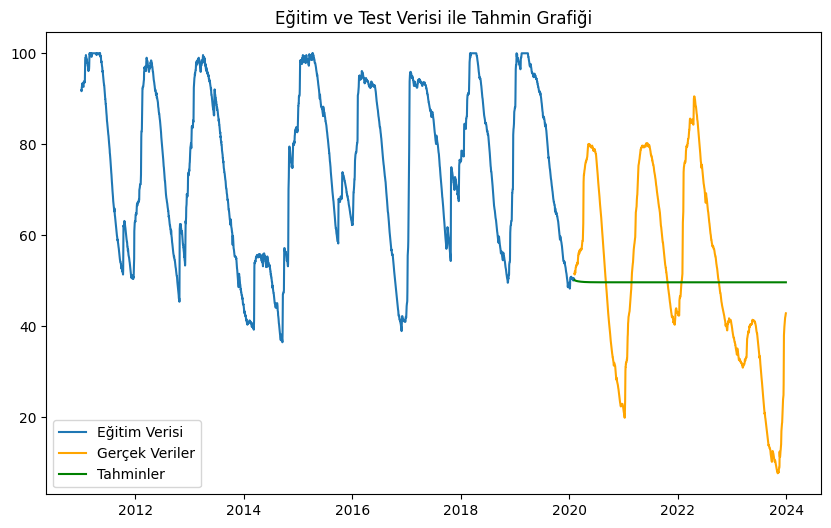

Mean Squared Error (MSE): 459.97994489269183
Root Mean Squared Error (RMSE): 21.447143047331313
Mean Absolute Error (MAE): 18.216845849106157
Mean Absolute Percentage Error (MAPE): 0.568544600425729%
R²: -0.0038453433728848907
Eğitim Süreti: 27.365055561065674 saniye
Çıkarım Süreti: 0.04523825645446777 saniye


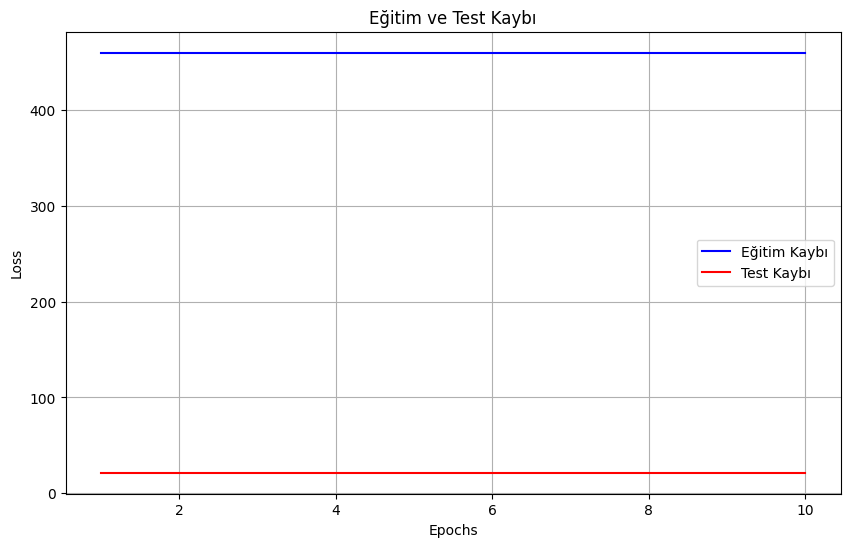

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import time

# ARIMA MODELLEMESI
df = pd.read_excel('terkosBarajı.xlsx')
print(df.columns)

# Tarih sütununu datetime formatına çevirin
df['datetime'] = pd.to_datetime(df['datetime'])

# Veriyi tarihe göre sıralama
df = df.sort_values(by='datetime')

# Ağırlıkları belirleyin
weights = {
    'temp': 0.4,

    'dew': 0.05,
    'humidity': 0.1,
    'precip': 0.7,
    'windspeed': 0.05,
    'sealevelpressure': 0.1,
    'cloudcover': 0.05,
    'daylight_duration': 0.12
}

# Baraj doluluk yüzdesi ve diğer bağımsız değişkenler
df = df[['datetime', 'temp', 'dew', 'humidity', 'precip',
       'windspeed', 'sealevelpressure', 'cloudcover', 'daylight_duration',
       'doluluk']]

# Ağırlıklı skor hesaplama
df['weighted_score'] = (weights['temp'] * df['temp'] +

                        weights['dew'] * df['dew'] +
                        weights['humidity'] * df['humidity'] +
                        weights['precip'] * df['precip'] +
                        weights['windspeed'] * df['windspeed'] +
                        weights['sealevelpressure'] * df['sealevelpressure'] +
                        weights['cloudcover'] * df['cloudcover'] +
                        weights['daylight_duration'] * df['daylight_duration'])

# Tarihi indeks olarak ayarlayın
df.set_index('datetime', inplace=True)

# Veriye göz atın
print(df.head())

# Baraj doluluk yüzdesi kolonunu hedef olarak seçin
y = df['doluluk']

# Veriyi eğitim ve test setlerine ayırın (shuffle=False)
train, test = train_test_split(y, test_size=0.3, shuffle=False)

# Eğitim ve test zamanlaması
start_time = time.time()  # Eğitim zamanını başlatma

# ARIMA modelini tanımlayın
model = ARIMA(train, order=(10,1,5)) #2 yıla göre tahmin eder 1 fark ile q=2 ise geçmiş hatalarla ilgilenmedir

# Modeli eğitin
model_fit = model.fit()

# Eğitim süreti
end_time = time.time()
training_time = end_time - start_time  # Eğitim süreti hesaplama

# Modelin özetine göz atın
print(model_fit.summary())

# Test verisi üzerinde tahmin yapın
start_inference_time = time.time()  # Çıkarım (inference) zamanını başlatma
predictions = model_fit.forecast(steps=len(test))
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time  # Çıkarım süreti

# Tahminleri görselleştirelim
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Eğitim Verisi')
plt.plot(test.index, test, label='Gerçek Veriler', color='orange')
plt.plot(test.index, predictions, label='Tahminler', color='green')
plt.legend()
plt.title('Eğitim ve Test Verisi ile Tahmin Grafiği')
plt.show()

# Modelin başarımını değerlendirelim
mse = mean_squared_error(test, predictions)
mse_rmse = np.sqrt(mse)  # RMSE
mae = mean_absolute_error(test, predictions)  # MAE
mape = mean_absolute_percentage_error(test, predictions)  # MAPE
r2 = r2_score(test, predictions)  # R²

# Sonuçları yazdırma
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {mse_rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R²: {r2}')
print(f'Eğitim Süreti: {training_time} saniye')
print(f'Çıkarım Süreti: {inference_time} saniye')

# Sonuçları Excel dosyasına kaydetme
result_df = pd.DataFrame({
    'Gerçek Değerler': test,
    'Tahminler': predictions
})

result_df.to_excel("baraj_doluluk_tahminleri.xlsx", index=True)

# Kaybın (Loss) Grafiği
epochs = 10
train_losses = [mse] * epochs
test_losses = [mse_rmse] * epochs

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Eğitim Kaybı", color='blue')
plt.plot(range(1, epochs + 1), test_losses, label="Test Kaybı", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Eğitim ve Test Kaybı")
plt.legend()
plt.grid(True)
plt.show()